# Autoregressive processes
* Theory
* Practical
    * Stationarise the data
    * Build a lag / series of lags
    * Make a prediction based on this lag/lags
    * Reconstruct - Undo stationarity on the prediction
    * Check autocorrelation
* Further reading:
    * Seasonal decomposition
    * Statsmodels AR model
    * Facebook Prophet


---

## Theory behind AR(P)

An autoregressive process is a stochastic process of the form:

$$
y_t = b + \sum_{j=1}^{P}w_{j}Y_{t-j} + \epsilon_t
$$

where $b$ is the bias, $w_j$ are the weights of the model and $\epsilon$ is some iid (e.g. Gaussian) noise. For the noise it holds that $E(\epsilon_t) = E(\epsilon) = 0$ and $V(\epsilon_t) = V(\epsilon) = \sigma^2$. E.g. expectation and variance are constant and time invariant.


For the case of $P=1$ we can write the process as:

$$
y_t = b + w_1Y_{t-1} + \epsilon_t
$$










---

### Practical:
* Stationarise the data
* Build a lag
* Predict
* Undo stationarity on the prediction
* Check autocorrelation

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = sns.load_dataset('flights')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


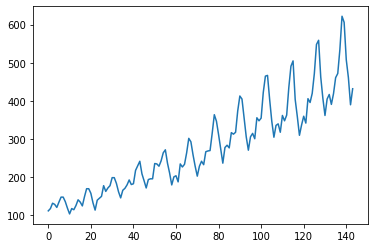

In [4]:
df.passengers.plot()

In [5]:
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df.set_index('Date', inplace=True)
df.head()

,year,month,passengers,datetime
Date,,,,
1949-01-01,1949,January,112,1949-01-01
1949-02-01,1949,February,118,1949-02-01
1949-03-01,1949,March,132,1949-03-01
1949-04-01,1949,April,129,1949-04-01
1949-05-01,1949,May,121,1949-05-01


In [7]:
del df['datetime']

In [8]:
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,January,112
1949-02-01,1949,February,118
1949-03-01,1949,March,132
1949-04-01,1949,April,129
1949-05-01,1949,May,121


---

## Stationarise the data


* What do we need to remove to ensure stationarity?

#### Trend

In [9]:
df['difference'] = df.passengers.diff() #this is a first order diff, apply for linear plots
# second order diffs will de-trend polynomial plots
# third order and above are rarely needed

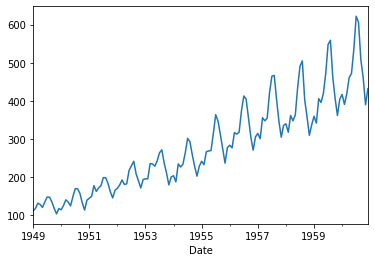

In [10]:
df.passengers.plot()

In [11]:
df.head()

,year,month,passengers,difference
Date,,,,
1949-01-01,1949,January,112,NaN
1949-02-01,1949,February,118,6.0
1949-03-01,1949,March,132,14.0
1949-04-01,1949,April,129,-3.0
1949-05-01,1949,May,121,-8.0


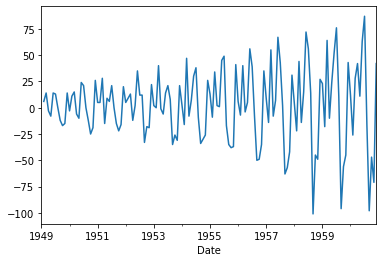

In [12]:
df.difference.plot()

#### Variance

In [13]:
df['log_diff'] = np.log(df.difference)

/home/tommu/anaconda3/envs/ds/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/tommu/anaconda3/envs/ds/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
df.difference.isnull()

Date
1949-01-01     True
1949-02-01    False
1949-03-01    False
1949-04-01    False
1949-05-01    False
              ...  
1960-08-01    False
1960-09-01    False
1960-10-01    False
1960-11-01    False
1960-12-01    False
Name: difference, Length: 144, dtype: bool

In [15]:
df.difference.mean()

2.237762237762238

In [16]:
#df = df.fillna(df.difference.mean())
df = df.fillna(method='bfill')

In [17]:
df['diff_log'] = np.log(df.passengers).diff()

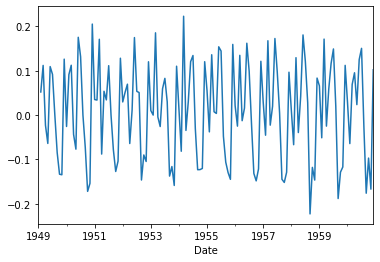

In [18]:
df.diff_log.plot() #first log passenger data, then do the diff of the log

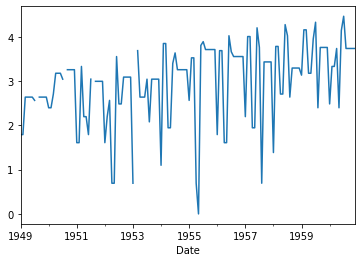

In [19]:
df.log_diff.plot() #first we do the difference, then do the log on the result

#### Seasonality

In [20]:
df.fillna(method='bfill', inplace=True)

In [21]:
df.head()

,year,month,passengers,difference,log_diff,diff_log
Date,,,,,,
1949-01-01,1949,January,112,6.0,1.791759,0.052186
1949-02-01,1949,February,118,6.0,1.791759,0.052186
1949-03-01,1949,March,132,14.0,2.639057,0.112117
1949-04-01,1949,April,129,-3.0,2.639057,-0.022990
1949-05-01,1949,May,121,-8.0,2.639057,-0.064022


In [22]:
df['monthly_means'] = df.groupby('month')['diff_log'].transform('mean')

In [23]:
df['deseasoned_diff_log'] = df.diff_log - df.monthly_means

In [24]:
df.head()

,year,month,passengers,difference,log_diff,diff_log,monthly_means,deseasoned_diff_log
Date,,,,,,,,
1949-01-01,1949,January,112,6.0,1.791759,0.052186,0.027407,0.024779
1949-02-01,1949,February,118,6.0,1.791759,0.052186,-0.011986,0.064172
1949-03-01,1949,March,132,14.0,2.639057,0.112117,0.140296,-0.028179
1949-04-01,1949,April,129,-3.0,2.639057,-0.022990,-0.021200,-0.001789
1949-05-01,1949,May,121,-8.0,2.639057,-0.064022,0.007696,-0.071718


In [36]:
def add_one(xx):
    return pd.Series([x+100 for x in xx])

In [31]:
df.passengers[:5]

Date
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: passengers, dtype: int64

In [38]:
df.passengers.transform(add_one)

0      212
1      218
2      232
3      229
4      221
      ... 
139    706
140    608
141    561
142    490
143    532
Length: 144, dtype: int64

In [25]:
#df.apply
#df.transform
## both these functions loop over each element in a pd.series(column of a df),
#and apply a function to the element

---

## Create a lag
* An autoregression model is a linear regression model that uses lagged variables as input variables, so we need to identify and define p
* The lag of p will be how far into the future we are predicting!

In [39]:
df.head()

,year,month,passengers,difference,log_diff,diff_log,monthly_means,deseasoned_diff_log
Date,,,,,,,,
1949-01-01,1949,January,112,6.0,1.791759,0.052186,0.027407,0.024779
1949-02-01,1949,February,118,6.0,1.791759,0.052186,-0.011986,0.064172
1949-03-01,1949,March,132,14.0,2.639057,0.112117,0.140296,-0.028179
1949-04-01,1949,April,129,-3.0,2.639057,-0.022990,-0.021200,-0.001789
1949-05-01,1949,May,121,-8.0,2.639057,-0.064022,0.007696,-0.071718


In [43]:
df['stationary_passengers'] = df.diff_log

In [47]:
del df['diff_log']

In [48]:
del df['log_diff']

In [49]:
df.head()

,year,month,passengers,difference,monthly_means,deseasoned_diff_log,stationary_passengers
Date,,,,,,,
1949-01-01,1949,January,112,6.0,0.027407,0.024779,0.052186
1949-02-01,1949,February,118,6.0,-0.011986,0.064172,0.052186
1949-03-01,1949,March,132,14.0,0.140296,-0.028179,0.112117
1949-04-01,1949,April,129,-3.0,-0.021200,-0.001789,-0.022990
1949-05-01,1949,May,121,-8.0,0.007696,-0.071718,-0.064022


In [66]:
for i in range(1,13):
    df[f'{i}_shift_st_p'] = df.stationary_passengers.shift(i)

In [67]:
df = df.fillna(method='bfill')

In [68]:
df.head()

,year,month,passengers,difference,monthly_means,deseasoned_diff_log,stationary_passengers,1_shift_st_p,2_shift_st_p,3_shift_st_p,4_shift_st_p,5_shift_st_p,6_shift_st_p,7_shift_st_p,8_shift_st_p,9_shift_st_p,10_shift_st_p,11_shift_st_p,12_shift_st_p
Date,,,,,,,,,,,,,,,,,,,
1949-01-01,1949,January,112,6.0,0.027407,0.024779,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186
1949-02-01,1949,February,118,6.0,-0.011986,0.064172,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186
1949-03-01,1949,March,132,14.0,0.140296,-0.028179,0.112117,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186
1949-04-01,1949,April,129,-3.0,-0.021200,-0.001789,-0.022990,0.112117,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186
1949-05-01,1949,May,121,-8.0,0.007696,-0.071718,-0.064022,-0.022990,0.112117,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186,0.052186


---

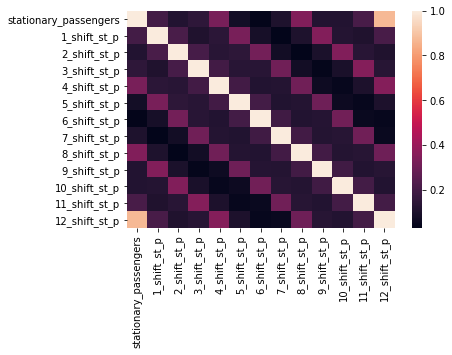

In [69]:
sns.heatmap(df.drop([x for x in df.columns if 'st' not in x], axis=1).corr().abs())

In [98]:
feature = ['12_shift_st_p']

## Predict

### Train-Test Split:
- Last 20 months -> Testing
- All months except the Last 20 -> Training

In [99]:
Xtrain = df[:-20][feature] 
Xtest = df[-20:][feature] 
ytrain = df[:-20]['stationary_passengers']
ytest = df[-20:]['stationary_passengers']

In [100]:
from sklearn.linear_model import LinearRegression

In [101]:
m = LinearRegression()

In [102]:
m.fit(Xtrain,ytrain)

LinearRegression()

In [103]:
#in_sample_ypred = m.predict(Xtrain) #in sample prediction
ypred = m.predict(Xtest) #out of sample prediction

In [104]:
Xtrain.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1958-07-01', '1958-08-01', '1958-09-01', '1958-10-01',
               '1958-11-01', '1958-12-01', '1959-01-01', '1959-02-01',
               '1959-03-01', '1959-04-01'],
              dtype='datetime64[ns]', name='Date', length=124, freq=None)

In [105]:
Xtest.index

DatetimeIndex(['1959-05-01', '1959-06-01', '1959-07-01', '1959-08-01',
               '1959-09-01', '1959-10-01', '1959-11-01', '1959-12-01',
               '1960-01-01', '1960-02-01', '1960-03-01', '1960-04-01',
               '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01',
               '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

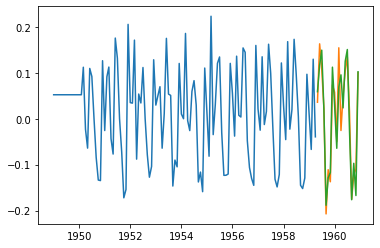

In [106]:
plt.plot(Xtrain)
plt.plot(Xtest.index, ypred) # orange line is our  stationary passenger prediction
plt.plot(Xtest.index, ytest) #green line is our actual stationary passenger data

In [107]:
m.score(Xtrain,ytrain), m.score(Xtest,ytest) 
#ratio of 'regression error' to 'error to the mean'
#this is the R-squared score - 1 means perfect, 0 terrible
#r squared improves as feature size improves, so use adjusted r-squared if you have lots of features

(0.7415784701510023, 0.8553066749135119)

---

## Reconstruct - Very important!

---

### Check auto-correlation

In [108]:
# !pip install --upgrade statsmodels
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

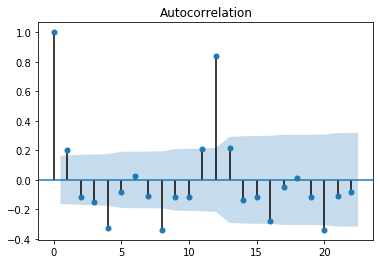

In [110]:
plot_acf(df.stationary_passengers) #take time lags outside the blue area with high correlation, for best results
None

ACF Plot Explained: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- "Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values **outside** of this code are very likely a correlation and **not** a statistical fluke."
- So basically, the AR model is taking the first 13 time lags because they are highly correlated with the prediction column (no. of passengers) and they are statistically significant.

---

## Checklist!! Apply this to your climate data:
* Stationarise the data
* Build a lag / series of lags
* Make a prediction based on this lag/lags
* Reconstruct - Undo stationarity on the prediction
* Check autocorrelation

---

### Further reading:
* Seasonal decomposition
* Statsmodels AR model
* Facebook Prophet
* non-manual - dickey-fuller, seasonal adjustment

#### Seasonal Decomposition

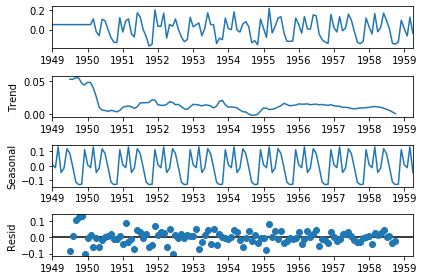

In [113]:
from statsmodels.tsa.seasonal import seasonal_decompose
sdc = seasonal_decompose(Xtrain, period=12, model='additive')
sdc.plot()
None

#### Statsmodel AR

In [ ]:
from statsmodels.tsa.ar_model import AR

ar = AR(df['passengers'])
ar_fitted = ar.fit()
ar_fitted.predict(end='1968')
ypred = ar_fitted.predict(end='1968')
plt.plot(ypred)
plt.plot(df['passengers'])

#### FB Prophet 

- https://facebook.github.io/prophet/docs/quick_start.html#python-api

#### Non-manual

- https://en.wikipedia.org/wiki/Seasonal_adjustment
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html